In [0]:
sc

SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
path_adult = "/databricks-datasets/adult/adult.data"

field_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "label"
]

df_adult = spark.read.csv(path_adult)
df_adult_original = df_adult
df_adult = df_adult.toDF(*field_names)

In [0]:
display(df_adult.describe())

summary,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
mean,38.58164675532078,null,189778.36651208502,null,10.0806793403151,null,null,null,null,null,1077.6488437087312,87.303829734959,40.437455852092995,null,null
stddev,13.640432553581356,null,105549.97769702227,null,2.572720332067397,null,null,null,null,null,7385.292084840354,402.960218649002,12.347428681731838,null,null
min,17,?,100009,10th,1,Divorced,?,Husband,Amer-Indian-Eskimo,Female,0,0,1,?,<=50K
max,90,Without-pay,99987,Some-college,9,Widowed,Transport-moving,Wife,White,Male,99999,974,99,Yugoslavia,>50K


## Wstępne obrebienie zbioru

In [0]:
df_adult.count() == df_adult.drop_duplicates().count()

Out[6]: False

In [0]:
df_adult = df_adult.drop_duplicates()

In [0]:
import pyspark.sql.functions as F

def nullify_col_with_question_mark(df_adult, column_name):
    return df_adult.withColumn(
        column_name,
        F.when(F.trim(df_adult[column_name]) == "?", None)\
            .otherwise(df_adult[column_name])
    )

df_adult = nullify_col_with_question_mark(df_adult, 'workclass')
df_adult = nullify_col_with_question_mark(df_adult, 'occupation')
df_adult = nullify_col_with_question_mark(df_adult, 'native-country')


In [0]:
df_adult = df_adult.dropna()

# Przygotowanie zbioru pod zastosowanie algorytmu

In [0]:
label_column = 'label'
skip_columns = ['fnlwgt', 'education-num']

category_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]

numerical_columns = [
    'age',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

W wypadku kategorii z pomocą przyjdzie nam StringIndexer. Żeby uzyskać przetworzony DF, należy stworzyć estimator, dopasować do niego zbiór metodą fit. Potem, utworzonym obiektem transformer — modelem, przetworzyć nasz DF przy pomocy transform. Zwykle szkielet procedury będzie podobny, dlatego zobacz, jak to się robi na przykładzie przetwarzania kategorii w liczby.

In [0]:
from pyspark.ml.feature import StringIndexer

category_index_columns = [
    "cat_" + column_name
    for column_name in category_columns
]

indexerFeatureColumns = StringIndexer(
    inputCols=category_columns,
    outputCols=category_index_columns
)

indexerModel = indexerFeatureColumns.fit(df_adult)
df_adult = indexerModel.transform(df_adult)

In [0]:
df_adult.columns

Out[12]: ['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'label',
 'cat_workclass',
 'cat_education',
 'cat_marital-status',
 'cat_occupation',
 'cat_relationship',
 'cat_race',
 'cat_sex',
 'cat_native-country']

Kolejnym dobrym krokiem będzie otrzymanie wektora, który zawiera cyfry 0 i 1. Jest to popularny typ obiektu, zwany też wektorem rzadkim. Zawiera on bardzo dużo zer i niewiele jedynek. Możesz się spotkać też z określeniem kodowanie one-hot. Powód, dla którego je stosujemy, jest taki, że zwykłe numeryczne kategorie sugerują istnienie nieprawdziwych relacji pomiędzy nimi (np. porządek, sąsiedztwo), co może wprowadzać w błąd algorytmy ML.

In [0]:
from pyspark.ml.feature import OneHotEncoder

onehot_names = [
    "vector_" + column_name
    for column_name in category_columns
]

encoder = OneHotEncoder(
    inputCols=category_index_columns,
    outputCols=onehot_names
)

encoderModel = encoder.fit(df_adult)
df_adult = encoderModel.transform(df_adult)

Podczas odczytu kolumn poszliśmy na skróty i nie zadeklarowaliśmy schematu dla każdej z kolumn. Dlatego też typ naszych kolumn jest tekstowy. Musimy go zamienić na liczby, wcześniej wycinając puste znaki z komórek. Posłużymy się do tego poniższą transformacją:

In [0]:
def text_to_numerical(df, columns):
    for column in columns:
        df = df.withColumn("num_"+column, F.trim(F.col(column)).cast('int'))
    return df

df_adult = text_to_numerical(df_adult, numerical_columns)

numerical_columns_withsuffix = ["num_" + name for name in numerical_columns]

Macierz zmiennych, które będą dostarczone do naszego modelu, musimy zmieścić do jednej kolumny. Na szczęście nie musimy tego robić ręcznie. Posłużymy się tu agregatorem o nazwie VectorAssembler. Podczas jego tworzenia podamy nazwy kolumn wejściowych i jednej kolumny wejściowej, w której znajdą się wszystkie wartości połączone w zbiorczy wektor. Jest to transformer, więc nie potrzebujemy wywoływać fit

In [0]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols = onehot_names + numerical_columns_withsuffix,
    outputCol = "features"
)

df_adult = assembler.transform(df_adult)

In [0]:
df_adult[['features']].head()

Out[16]: Row(features=SparseVector(94, {2: 1.0, 7: 1.0, 21: 1.0, 29: 1.0, 40: 1.0, 46: 1.0, 49: 1.0, 50: 1.0, 90: 44.0, 93: 38.0}))

Etykiety też muszą być liczbami, dlatego użyjemy StringIndexer raz jeszcze, tym razem dla kolumny label.

In [0]:
label_indexer = StringIndexer(
    inputCol="label",
    outputCol="indexedLabel"
)
df_adult = label_indexer.fit(df_adult).transform(df_adult)

## Drzewo decyzyjne

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

In [0]:
classifier = DecisionTreeClassifier(
    labelCol="indexedLabel",
    featuresCol="features"
)

model = classifier.fit(df_adult)
df_predictions = model.transform(df_adult)

In [0]:
display(df_predictions.select([
    'indexedLabel','rawPrediction','probability','prediction'
]).take(9))

indexedLabel,rawPrediction,probability,prediction
1.0,"Map(vectorType -> dense, length -> 2, values -> List(6367.0, 2854.0))","Map(vectorType -> dense, length -> 2, values -> List(0.6904891009651881, 0.3095108990348118))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(2789.0, 465.0))","Map(vectorType -> dense, length -> 2, values -> List(0.8570989551321451, 0.14290104486785496))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(12150.0, 345.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9723889555822329, 0.027611044417767107))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(6367.0, 2854.0))","Map(vectorType -> dense, length -> 2, values -> List(0.6904891009651881, 0.3095108990348118))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(12150.0, 345.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9723889555822329, 0.027611044417767107))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(12150.0, 345.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9723889555822329, 0.027611044417767107))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(12150.0, 345.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9723889555822329, 0.027611044417767107))",0.0
0.0,"Map(vectorType -> dense, length -> 2, values -> List(12150.0, 345.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9723889555822329, 0.027611044417767107))",0.0
1.0,"Map(vectorType -> dense, length -> 2, values -> List(689.0, 1190.0))","Map(vectorType -> dense, length -> 2, values -> List(0.36668440659925494, 0.6333155934007451))",1.0


In [0]:
df_train, df_test = df_adult.randomSplit([0.7, 0.3], seed=42)

classifier = DecisionTreeClassifier(
    labelCol="indexedLabel",
    featuresCol="features"
)

model = classifier.fit(df_train)
df_test = model.transform(df_test)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='indexedLabel',
    metricName='areaUnderROC'
)

evaluator.evaluate(df_test)

Out[23]: 0.6919278386727228

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(df_test['indexedLabel','prediction'].rdd)
print('Confusion Matrix:\n', metrics.confusionMatrix())

Confusion Matrix:
 DenseMatrix([[6302., 1150.],
             [ 334., 1062.]])


In [0]:
y_true = df_test.select(['indexedLabel']).collect()
y_pred = df_test.select(['prediction']).collect()

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89      6636
         1.0       0.76      0.48      0.59      2212

    accuracy                           0.83      8848
   macro avg       0.80      0.71      0.74      8848
weighted avg       0.82      0.83      0.82      8848



## Regresja liniowa

In [0]:
from pyspark.ml.classification import LogisticRegression

In [0]:
classifier = LogisticRegression(
    labelCol="indexedLabel",
    featuresCol="features"
)

model = classifier.fit(df_adult)
df_predictions = model.transform(df_adult)

In [0]:
df_train, df_test = df_adult.randomSplit([0.7, 0.3], seed=42)

classifier = LogisticRegression(
    labelCol="indexedLabel",
    featuresCol="features"
)

model = classifier.fit(df_train)
df_test = model.transform(df_test)

In [0]:
y_true = df_test.select(['indexedLabel']).collect()
y_pred = df_test.select(['prediction']).collect()

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      6636
         1.0       0.75      0.60      0.66      2212

    accuracy                           0.85      8848
   macro avg       0.81      0.77      0.78      8848
weighted avg       0.84      0.85      0.84      8848



# Regresja egzaminy z matematyki

In [0]:
# File location and type
file_location = "/FileStore/tables/student_mat.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.take(5))

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [0]:
from pyspark.ml.feature import VectorAssembler
# defining end exam score as our label/predictor variable
dataset = df.select(df.G1, df.studytime, df.absences, df.G3.alias('label'))

# split data into 70% training and 30% testing data
training, test = dataset.randomSplit([0.7, 0.3], seed = 100)

# assembler to assemble the features into vector form
assembler = VectorAssembler().setInputCols(['G1','studytime', 'absences' ]).setOutputCol('features')
trainingSet = assembler.transform(training)

# select only features column and label column since we have already vectorised our features
trainingSet = trainingSet.select("features","label")

In [0]:
from pyspark.ml.regression import LinearRegression

# fit the training set to linear regression model
lr = LinearRegression()
lr_Model = lr.fit(trainingSet)

# assembler to assemble the features into vector form
testSet = assembler.transform(test)

# select only features column and label column since we have already vectorised our features
testSet = testSet.select("features", "label")

# fit the testing data into our linear regression model
testSet = lr_Model.transform(testSet)
testSet.show(truncate=False)

+--------------+-----+------------------+
|features      |label|prediction        |
+--------------+-----+------------------+
|[5.0,1.0,0.0] |0    |3.8109799486355476|
|[6.0,1.0,0.0] |0    |4.9218350809795375|
|[6.0,1.0,0.0] |0    |4.9218350809795375|
|[6.0,1.0,4.0] |8    |5.062510812883876 |
|[6.0,1.0,7.0] |6    |5.168017611812131 |
|[6.0,1.0,16.0]|5    |5.4845380085968936|
|[6.0,1.0,16.0]|8    |5.4845380085968936|
|[6.0,2.0,2.0] |6    |4.8230451799697525|
|[6.0,2.0,13.0]|8    |5.209903442706684 |
|[7.0,1.0,0.0] |0    |6.032690213323527 |
|[7.0,1.0,0.0] |0    |6.032690213323527 |
|[7.0,1.0,0.0] |0    |6.032690213323527 |
|[7.0,1.0,2.0] |8    |6.103028079275697 |
|[7.0,1.0,5.0] |7    |6.208534878203951 |
|[7.0,1.0,14.0]|5    |6.525055274988714 |
|[7.0,2.0,2.0] |7    |5.933900312313742 |
|[7.0,2.0,5.0] |7    |6.039407111241996 |
|[7.0,2.0,25.0]|11   |6.742785770763692 |
|[7.0,2.0,26.0]|6    |6.777954703739776 |
|[7.0,3.0,0.0] |8    |5.694434679399618 |
+--------------+-----+------------

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
print(evaluator.evaluate(testSet, {evaluator.metricName: "r2"}))

0.6435628463908436


Pandas

In [0]:
import pandas as pd
import numpy as np

stud_mat = df.toPandas()
stud_mat.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10


In [0]:
simple_reg = stud_mat[['G1','G3']]
simple_reg.describe()

,G1,G3
count,395.000000,395.000000
mean,10.908861,10.415190
std,3.319195,4.581443
min,3.000000,0.000000
25%,8.000000,8.000000
50%,11.000000,11.000000
75%,13.000000,14.000000
max,19.000000,20.000000


Out[85]: Text(0, 0.5, 'G3')

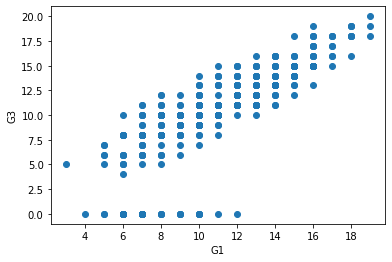

In [0]:
import matplotlib.pyplot as plt
plt.scatter(stud_mat['G1'],stud_mat['G3'])
plt.xlabel('G1')
plt.ylabel('G3')

In [0]:
clean_simple_reg = simple_reg[simple_reg['G3']>0]
y = clean_simple_reg['G3']
x1 = clean_simple_reg['G1']

Out[87]: Text(0, 0.5, 'G3')

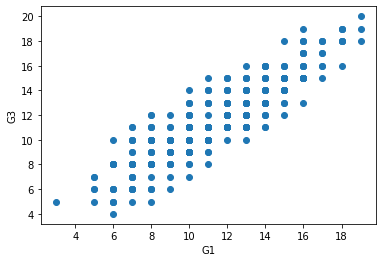

In [0]:
plt.scatter(x1,y)
plt.xlabel('G1')
plt.ylabel('G3')

In [0]:
import statsmodels.api as sm

x = sm.add_constant(x1)
model = sm.OLS(y,x).fit()

model.summary()

OLS Regression Results 
 
 Dep. Variable: G3 R-squared: 0.795 
 
 
 Model: OLS Adj. R-squared: 0.795 
 
 
 Method: Least Squares F-statistic: 1379. 
 
 
 Date: Thu, 09 Dec 2021 Prob (F-statistic): 2.47e-124 
 
 
 Time: 13:36:43 Log-Likelihood: -641.24 
 
 
 No. Observations: 357 AIC: 1286. 
 
 
 Df Residuals: 355 BIC: 1294. 
 
 
 Df Model: 1 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 1.5134 0.280 5.397 0.000 0.962 2.065 
 
 
 G1 0.8883 0.024 37.140 0.000 0.841 0.935 
 
 
 
 
 Omnibus: 3.940 Durbin-Watson: 1.697 
 
 
 Prob(Omnibus): 0.139 Jarque-Bera (JB): 3.518 
 
 
 Skew: 0.169 Prob(JB): 0.172 
 
 
 Kurtosis: 2.650 Cond. No. 42.8 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

Out[89]: Text(0, 0.5, 'G3')

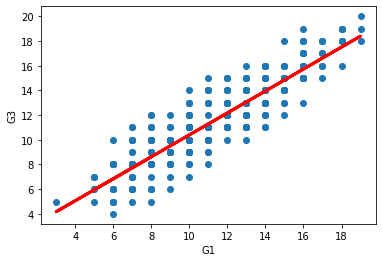

In [0]:
y_model = 0.8883*x1 + 1.5134
plt.plot(x1,y_model,color='red',lw=3)

plt.scatter(x1,y)

plt.xlabel('G1')
plt.ylabel('G3')

In [0]:
pd.get_dummies(stud_mat['sex'],drop_first=True)

,M
0,0
1,0
2,0
3,0
4,0
...,...
390,1
391,1
392,1
393,1


In [0]:
def normalize(X):
    scaled_X = X.copy()
    for col in scaled_X.columns:
        scaled_X[col] = (scaled_X[col]-scaled_X[col].min())/(scaled_X[col].max()-scaled_X[col].min())

    return scaled_X

clean_stud_mat = stud_mat[stud_mat['G3']>0]
scaled_x = normalize(clean_stud_mat[['absences','G1']])

In [0]:
x = pd.concat([scaled_x,pd.get_dummies(clean_stud_mat['sex'],drop_first=True)],axis=1)

x1 = sm.add_constant(x)
y = clean_stud_mat['G3']
model = sm.OLS(y,x1).fit()
model.summary()

OLS Regression Results 
 
 Dep. Variable: G3 R-squared: 0.807 
 
 
 Model: OLS Adj. R-squared: 0.805 
 
 
 Method: Least Squares F-statistic: 491.2 
 
 
 Date: Thu, 09 Dec 2021 Prob (F-statistic): 1.38e-125 
 
 
 Time: 13:37:33 Log-Likelihood: -631.00 
 
 
 No. Observations: 357 AIC: 1270. 
 
 
 Df Residuals: 353 BIC: 1286. 
 
 
 Df Model: 3 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 4.5343 0.231 19.658 0.000 4.081 4.988 
 
 
 absences -3.1597 0.699 -4.521 0.000 -4.534 -1.785 
 
 
 G1 13.9973 0.377 37.114 0.000 13.256 14.739 
 
 
 M 0.0451 0.152 0.296 0.767 -0.254 0.344 
 
 
 
 
 Omnibus: 1.823 Durbin-Watson: 1.734 
 
 
 Prob(Omnibus): 0.402 Jarque-Bera (JB): 1.796 
 
 
 Skew: 0.109 Prob(JB): 0.407 
 
 
 Kurtosis: 2.730 Cond. No. 11.7 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.